### Importing 

In [1]:
import numpy as np
import hidden_markov
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
import csv
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Data Cleaning, Imputation and Occupation Grouping

### Make Dictionary from Occupation Number to Group Number

Occupation Groups (and their number):

1. Management Occupations
2. Business and Financial Operations Occupations
3. Computer and mathematical occupations
4. Architecture and Engineering Occupations
5. Life; Physical; and Social Science Occupations
6. Community and Social Services Occupations
7. Legal Occupations
8. Education; Training; and Library Occupations
9. Arts; Design; Entertainment; Sports; and Media Occupations
10. Healthcare Practitioner and Technical Occupations
11. Healthcare Support Occupations
12. Protective Service Occupations
13. Food Preparation and Serving Related Occupations
14. Building and Grounds Cleaning and Maintenance Occupations
15. Personal Care and Service Occupations
16. Sales and Related Occupations
17. Office and Administrative Support Occupations
18. Agriculture Workers including Supervisors
19. Fishing and Hunting; and Forest and Logging Workers
20. Construction and Extraction Occupations
21. Installation; Maintenance; and Repair Occupations
22. Production Occupations
23. Transportation and Material Moving Occupations
24. Military Occupations
25. Unemployed


all_occupations: dictionary which maps occupations numbers to a tuple of (occupation name, occupation group number)

occupation_groups: dictionary which maps occupation group number to tuple of (occupation group name, lower bound for numbers in group, upper bound for numbers in group)

In [3]:
all_occupations = dict()
occupation_groups =  dict()

with open("2002 Census Occupation Codes.csv", "r") as ins:
    array = []
    for line in ins:
        s = line.split(",")
        try:
            bounds = s[2].split("-")
            occupation_groups[int(s[0])] = [s[1][:-1],int(bounds[0]), int(bounds[1])]
            last_group = int(s[0])
        except:
            num = int(s[2])
            all_occupations[num] = [s[1],last_group]
            array.append(line)
            

In [4]:
occupation_groups2 =  {}

with open("CensusCodes1980.csv", "r") as ins:
    array = []
    for line in ins:
        s = line.split(",")
        bounds = s[2].split("-")
        occupation_groups2[int(s[0])] = range(int(bounds[0]),int(bounds[1])+1)            

### Code for Converting Occupation Number to Group Number

In [5]:
def occupationNum_to_groupNum(occupation_num, all_occupations):
    try:
        return all_occupations[occupation_num][1]
    except:
        if occupation_num < 0:
            return occupation_num
        else:
            return -10
            

In [6]:
def occupationNum_to_groupNum_1980(occupation_num, occupation_groups2):
    for i in occupation_groups2:
        if occupation_num in occupation_groups2[i]:
            return i
    if occupation_num < 0:
        return occupation_num
    return -10
        

# Impute Data

Imputation: 
1. Convert occupation numbers to occupation group numbers
2. Remove instance from data set if all the values are missing
3. If imputation_type = 'remove_leading', remove leading missing values from array
4. Impute data based on looking at closest non-missing data on both sides of missing value
    -if the left = right, impute missing value with the left/right value
    -if the left != right, for ANY missing value in the array, remove instance from data set

In [7]:
def imputation(a, imputation_type):
    """imputation_type:
    normal: if a missing value sits between two of the same number, 
    replace the missing value with this number. Else, throw line away
    remove_leading: remove any leading missing data and interpolate normally  
    """

    #first transfer occupation numbers to group numbers
    all_missing = True
    has_incorrect_occnum = False
    for i in range(len(a)):
        if int(a[i]) > 0:
            all_missing = False
        a[i] = occupationNum_to_groupNum(int(a[i]), all_occupations)
        if a[i] == -10:
            has_incorrect_occnum = True
            
    #if we have purely missing data or the row contains a career code that isnt
    #in the occupation codes file
    if all_missing or has_incorrect_occnum:  
        return []
    
    #remove leading missing data, based on scheme
    array = []
    flag = False    
    for i in range(len(a)):
        if int(a[i]) > 0:
            flag = True
        if flag == True:
            array.append(a[i])
        else:     
            #if imputation_type == remove_leading, do nothing 
            if imputation_type == 'normal':
                array.append(a[i])    
                
    both_sides_same = True
    for i in range(len(array)):
        if int(array[i]) < 0: #if we are considering missing data
            j = i
            while j < len(array)-1 and int(array[j]) < 0:
                j += 1
            right = int(array[j])
            
            k = i
            while k > 0 and  int(array[k]) < 0 :
                k -= 1
            left = int(array[k])   

            #if both left and right are the same, and a valid occupation, impute 
            if left == right and left > 0:
                array[i] = right
            elif right < 0: #impute missing values at end of array
                array[i] = left
            else: #if both sides aren't the same, ignore this line
                both_sides_same = False
        
    """if the line is "invalid" because leading missing data or couldn't impute value within
    the array, then "throw" this line away """
    if both_sides_same == True:
        return array
    else: 
        return []

In [8]:
def write_cleaned_data_to_file(impute_type, filename):
    new_data = []
    num = []
    with open('data.csv') as f1:
        for line in f1:
            s1 = line.replace('\r\n', '')
            sl = s1.split(',')
            if sl[0] != 'R0000100' and sl[0] != 'PUBID_1997': #if these are metadata lines, ignore
                new_line = imputation(sl[7:22],impute_type) 
                if new_line != []:
                    new_data.append(new_line)
                
    np.random.shuffle(new_line)
    for i in range(len(new_data)):
        for j in range(len(new_data[i])):
            new_data[i][j] = int(new_data[i][j])
            
    with open(filename, "wb") as f:
        writer = csv.writer(f)
        writer.writerows(new_data)

 
#write_cleaned_data_to_file('remove_leading','CleanedDataLeadingRemovedInt.csv')
#write_cleaned_data_to_file('remove_leading','CleanedDataLeadingRemoved.csv')
#write_cleaned_data_to_file('normal','CleanedData.csv')

In [9]:
def imputation1980(a, imputation_type):
    """imputation_type:
    normal: if a missing value sits between two of the same number, 
    replace the missing value with this number. Else, throw line away
    remove_leading: remove any leading missing data and interpolate normally  
    """

    #first transfer occupation numbers to group numbers
    all_missing = True
    has_incorrect_occnum = False
    for i in range(len(a)):
        if int(a[i]) > 0:
            all_missing = False
        a[i] = occupationNum_to_groupNum_1980(int(a[i]), occupation_groups2)
        if a[i] == -10:
            has_incorrect_occnum = True
            
    #if we have purely missing data or the row contains a career code that isnt
    #in the occupation codes file
    if all_missing or has_incorrect_occnum:  
        return []
    
    #remove leading missing data, based on scheme
    array = []
    flag = False    
    for i in range(len(a)):
        if int(a[i]) > 0:
            flag = True
        if flag == True:
            array.append(a[i])
        else:     
            #if imputation_type == remove_leading, do nothing 
            if imputation_type == 'normal':
                array.append(a[i])    
                
    both_sides_same = True
    for i in range(len(array)):
        if int(array[i]) < 0: #if we are considering missing data
            j = i
            while j < len(array)-1 and int(array[j]) < 0:
                j += 1
            right = int(array[j])
            
            k = i
            while k > 0 and  int(array[k]) < 0 :
                k -= 1
            left = int(array[k])   

            #if both left and right are the same, and a valid occupation, impute 
            if left == right and left > 0:
                array[i] = right
            elif right < 0: #impute missing values at end of array
                array[i] = left
            else: #if both sides aren't the same, ignore this line
                both_sides_same = False
        
    """if the line is "invalid" because leading missing data or couldn't impute value within
    the array, then "throw" this line away """
    if both_sides_same == True:
        return array
    else: 
        return []

In [10]:
def write_cleaned_data_to_file1980(impute_type, filename):
    new_data = []
    num = []
    with open('occupations1979.csv') as f1:
        for line in f1:
            s1 = line.replace('\r\n', '')
            sl = s1.split(',')
            if sl[0] != 'A0002500' and sl[0] != 'VERSION_R25_2012': #if these are metadata lines, ignore
                new_line = imputation1980(sl[4:],impute_type) 
                if new_line != []:
                    new_data.append(new_line)
                
    np.random.shuffle(new_line)
    for i in range(len(new_data)):
        for j in range(len(new_data[i])):
            new_data[i][j] = int(new_data[i][j])
            
    with open(filename, "wb") as f:
        writer = csv.writer(f)
        writer.writerows(new_data)

write_cleaned_data_to_file1980('remove_leading','CleanedDataLeadingRemoved1979.csv')

#write_cleaned_data_to_file('remove_leading','CleanedDataLeadingRemovedInt.csv')
#write_cleaned_data_to_file('remove_leading','CleanedDataLeadingRemoved.csv')
#write_cleaned_data_to_file('normal','CleanedData.csv')

# Models

## Read in Data and Chunk it

In [11]:
xx = []
yy = []
with open('CleanedDataLeadingRemoved.csv') as f:
        for line in f:
            line = line.replace('\r\n','').split(',')
            for j in range(0,len(line)-3):
                xx.append([int(line[j]),int(line[j+1]),int(line[j+2])])
                yy.append(int(line[j+3]))
#xx = np.array(xx)
#yy = np.array(yy)
x_test = []
x = []
y_test = []
y = []
index = int(len(xx)*0.2)
for i in range(len(xx)):
    if i <= index:
        x_test.append(xx[i])
        y_test.append(yy[i])
    else:
        x.append(xx[i])
        y.append(yy[i])

x_test = np.array(x_test)
y_test = np.array(y_test)
x = np.array(x)
y = np.array(y)

## Set up k-fold cross validation

In [3]:
def run_model(model_type):
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(x):
        X_train, X_valid = x[train_index], x[test_index]
        y_train, y_valid = y[train_index], y[test_index]
    
        clf = model_type
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_valid, y_valid))

    return sum(scores)/5.0

In [4]:
#Multinomial Model- tune alpha
alphas = np.linspace(0,1,11)
for alpha in alphas:
    print alpha, run_model(MultinomialNB(alpha=alpha))
    
#so smoothing does not help, most likely because small state space and 
#lots of data, so large chance of encountering each triplet

0.0 0.166426351642
0.1 0.166426351642
0.2 0.166426351642
0.3 0.166426351642
0.4 0.166426351642
0.5 0.166426351642
0.6 0.166426351642
0.7 0.166426351642
0.8 0.166426351642
0.9 0.166426351642
1.0 0.166426351642


In [6]:
#Bernoulli Model- tune alpha 
alphas = np.linspace(0,1,11)
for alpha in alphas:
    print alpha, run_model(BernoulliNB(alpha = alpha))

#so perform some smoothing, alpha != 0 is optimal

0.0 0.0410393458705
0.1 0.155393111663
0.2 0.155393111663
0.3 0.155393111663
0.4 0.155393111663
0.5 0.155393111663
0.6 0.155393111663
0.7 0.155393111663
0.8 0.155393111663
0.9 0.155393111663
1.0 0.155393111663


In [7]:
#Gaussian Model
print run_model(GaussianNB())

0.374537269479


1 0.563907177159
2 0.610590198192
3 0.635157545258
4 0.672818848263
5 0.696561708927
6 0.708471101311
7 0.709527958468
8 0.712002743382
9 0.712569923123
10 0.712337947755
11 0.711409933316
12 0.711487279481
13 0.711023222423
14 0.71143567993
15 0.7105076522
16 0.710945899515
17 0.709914798941
18 0.70927033284
19 0.709064107409


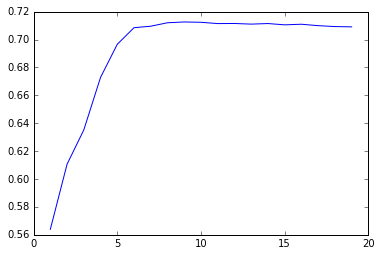

In [8]:
#K Nearest Neighbors Classifier- tune n
ns = range(1,20)
scores = []
for n in ns:
    score = run_model(KNeighborsClassifier(n_neighbors = n))
    print n, score 
    scores.append(score)

plt.plot(ns,scores)
plt.show()

#pick n= 9

10 0.715611814682
20 0.716978083082
30 0.717545222953
40 0.716720337842
50 0.717235894774
60 0.717235881484
70 0.717803024677
80 0.71739055388
90 0.717725688479


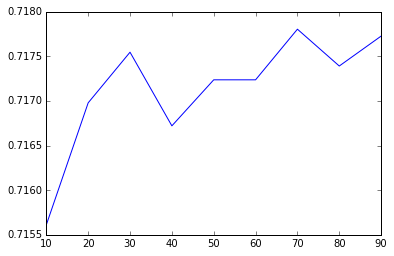

In [9]:
scores = []
ns = [10*i for i in range(1,10)]
for n in ns:
    score = run_model(BaggingClassifier(KNeighborsClassifier(n_neighbors=9), n_estimators = n))
    print n, score 
    scores.append(score)
    
plt.plot(ns,scores)
plt.show()

#70 bags is optimal

50 0.717364754104
100 0.717519433145
150 0.718318548384
200 0.718447457553
250 0.718421714261
300 0.718035010013
350 0.718060823079
400 0.718189692377


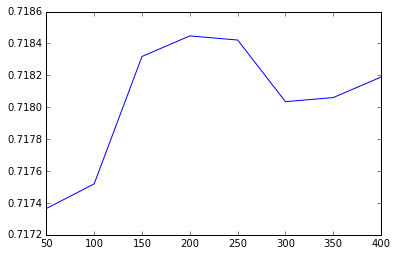

In [10]:
# Random Forest Classifier- tune n_estimators
ns = [i*50 for i in range(1,9)]
np.insert(ns,0,1)
scores = []
for n in ns:
    score = run_model(RandomForestClassifier(n_estimators=n))
    print n, score 
    scores.append(score)

plt.plot(ns,scores)
plt.show()

#250 bags is optimal

## Test Set

In [11]:
def test(model_type):
    clf = model_type
    clf.fit(x, y)
    return clf.score(x_test, y_test)

print test(MultinomialNB(alpha=1.0))
print test(BernoulliNB(alpha = 1.0))
print test(GaussianNB())
print test(KNeighborsClassifier(n_neighbors = 9))
print test(BaggingClassifier(KNeighborsClassifier(n_neighbors=9), n_estimators = 70))
print test(RandomForestClassifier(n_estimators=250))

0.205278894731
0.194040622745
0.339519538097
0.731621816682
0.739560779462
0.74100422724


In [7]:
def test():
    clf = RandomForestClassifier(n_estimators=250)
    clf.fit(x, y)
    print clf.feature_importances_
    #return clf.score(x_test, y_test)
    
test()

[ 0.19812759  0.27798113  0.52389128]
